<a href="https://colab.research.google.com/github/risitadas/Recommendation-System-on-MovieLens-Dataset/blob/main/Recommender_System_using_Softmax_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**loading the libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
import tensorflow as tf
import keras
from pprint import pprint

In [4]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [5]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

--2022-12-30 19:15:50--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  16.4MB/s    in 0.3s    

2022-12-30 19:15:51 (16.4 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

**loading MovieLens dataset**

In [6]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print("details of users, items and ratings involved in the loaded movielens dataset: ",list(overall_stats[0]))

details of users, items and ratings involved in the loaded movielens dataset:  ['943 users', '1682 items', '100000 ratings']


we see 100000 ratings by 943 users on 1682 items.

each user has rated at least 20 movies.  Users and items are numbered consecutively from 1and also the data is randomly ordered

    list of 
     user id | item id | rating |timestamp

renaming item id column as movie id as they are the same.

In [7]:
column_names1 = ['user id','movie id','rating','timestamp']
ratings_dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
ratings_dataset.head() 

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


    list of
          movie id | movie title | release date | video release date |
          IMDb URL | unknown | Action | Adventure | Animation |
          Children's | Comedy | Crime | Documentary | Drama | Fantasy |
          Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
          Thriller | War | Western |


last 19 fields are the genres, 
1 indicates the movie is of that genre, 0 indicates it is not and movies can be in several genres at once.

In [8]:
d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
print(column_names2)

['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [9]:
items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


length of the original items_Dataset and the length of unique combination of rows in items_dataset after removing of movie id column.

In [11]:
len(items_dataset.groupby(by=column_names2[1:])),len(items_dataset)

(1664, 1682)

**merging required datasets**

In [12]:
merged_dataset = pd.merge(ratings_dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()

,user id,movie id,rating,timestamp,movie title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


the above dataset is created from the existing merged dataset by grouping the unique user id and movie title combination and the ratings by a user to the same movie in different instances (timestamps) are averaged and stored in the new dataset.

for example : 

In [13]:
merged_dataset[(merged_dataset['movie title'] == 'Chasing Amy (1997)') & (merged_dataset['user id'] == 894)]

,user id,movie id,rating,timestamp,movie title
4800,894,246,4,882404137,Chasing Amy (1997)
22340,894,268,3,879896041,Chasing Amy (1997)


**creating a final refined dataset with unique user id, movie name combination and their ratings:**

In [14]:
refined_dataset = merged_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


**encoding users and movie titles to make sure that the sequence has no missing values when dealing with Deep Neural Networks**

In [15]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user id'].values)
n_users = refined_dataset['user'].nunique()

In [16]:
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['movie title'].values)
n_movies = refined_dataset['movie'].nunique()

In [17]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(943, 1664, 1.0, 5.0)

In [18]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


**splitting the data into training and testing**

In [19]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89723, 2), (9970, 2), (89723,), (9970,))

**number of factors which are to be considered by the Embedding layer**

In [20]:
n_factors = 150

now, columns in the input array are split into two separate arrays, as we know Keras considers them as two distinct inputs, each input are fed to their own array respectively.

In [21]:
X_train_array = [X_train[:,0], X_train[:,1]]
X_test_array = [X_test[:,0], X_test[:,1]]

In [22]:
X_train, X_train_array, X_train_array[0].shape

(array([[ 180, 1152],
        [ 487,  389],
        [ 177,  302],
        ...,
        [ 431, 1588],
        [ 232,  399],
        [ 138,  612]]),
 [array([180, 487, 177, ..., 431, 232, 138]),
  array([1152,  389,  302, ..., 1588,  399,  612])],
 (89723,))

**normalizing the labels**

In [23]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

**building a Softmax Deep Neutral Network**

In [24]:
import tensorflow as tf

In [26]:
# initializing input layer for users
user = tf.keras.layers.Input(shape = (1,))

# embedding layer for n_factors of users
#u = tf.keras.layers.embeddings.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

# initializing input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

# embedding layer for n_factors of movies
#m = keras.layers.embeddings.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

# stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

# adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

# adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

# adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

# defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)


# compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 150)       141450      ['input_3[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 150)       249600      ['input_4[0][0]']                
                                                                                              

In [28]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=70, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])


Epoch 1/70
701/701 [==============================] - 6s 7ms/step - loss: 0.8413 - accuracy: 0.0608 - val_loss: 0.5301 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 2/70
701/701 [==============================] - 5s 7ms/step - loss: 0.5377 - accuracy: 0.0609 - val_loss: 0.5141 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 3/70
701/701 [==============================] - 5s 7ms/step - loss: 0.5281 - accuracy: 0.0609 - val_loss: 0.5108 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 4/70
701/701 [==============================] - 6s 8ms/step - loss: 0.5235 - accuracy: 0.0609 - val_loss: 0.5097 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 5/70
701/701 [==============================] - 5s 7ms/step - loss: 0.5208 - accuracy: 0.0609 - val_loss: 0.5077 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 6/70
701/701 [==============================] - 5s 7ms/step - loss: 0.5180 - accuracy: 0.0609 - val_loss: 0.5056 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 7/70
701/701 [==============================] - 5s 7ms/step - lo

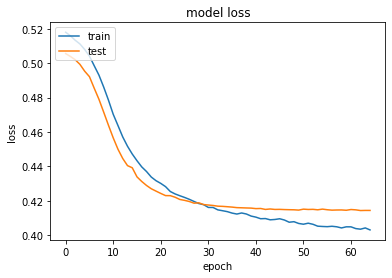

In [29]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

**getting movies for given User**

In [31]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


In [32]:
X_train_array

[array([180, 487, 177, ..., 431, 232, 138]),
 array([1152,  389,  302, ..., 1588,  399,  612])]

In [33]:
user_id = [777]
encoded_user_id = user_enc.transform(user_id)

seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id[0]]['movie'])
print(seen_movies)

[7, 55, 87, 113, 313, 337, 389, 390, 399, 411, 432, 460, 498, 528, 580, 604, 612, 643, 666, 783, 996, 1005, 1032, 1102, 1132, 1157, 1190, 1208, 1251, 1260, 1284, 1302, 1342, 1523, 1558, 1615]


In [34]:
len(refined_dataset['movie'].unique()), min(refined_dataset['movie']), max(refined_dataset['movie'])

(1664, 0, 1663)

In [35]:
unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
print(unseen_movies)

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 

movies which are not seen by the user

In [ ]:
len(unseen_movies) + len(seen_movies)

In [37]:
model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
len(model_input), len(model_input[0])

(2, 1628)

**DNN model is used to predict the rating of the unseen movies**

In [38]:
predicted_ratings = model.predict(model_input)

51/51 [==============================] - 0s 2ms/step


In [39]:
print(predicted_ratings.shape)

(1628, 9)


In [40]:
print(predicted_ratings)

[[8.8652623e-01 1.1342055e-01 4.5115594e-06 ... 1.2028187e-05
  7.0740007e-06 2.7963849e-06]
 [8.0248421e-01 1.9744630e-01 6.3210982e-06 ... 1.6137457e-05
  9.1515512e-06 3.5986077e-06]
 [9.2970496e-01 7.0246212e-02 4.0660111e-06 ... 1.0468610e-05
  7.1644326e-06 2.5420873e-06]
 ...
 [7.2042012e-01 2.7950042e-01 7.5591406e-06 ... 1.9509816e-05
  1.0452925e-05 4.1771586e-06]
 [7.5263548e-01 2.4730280e-01 5.8153473e-06 ... 1.5110252e-05
  7.6725546e-06 3.0263620e-06]
 [7.1339637e-01 2.8652105e-01 7.9292486e-06 ... 2.0172645e-05
  1.0476924e-05 4.1708481e-06]]


In [41]:
predicted_ratings = np.max(predicted_ratings, axis = 1)
predicted_ratings

array([0.8865262 , 0.8024842 , 0.92970496, ..., 0.7204201 , 0.7526355 ,
       0.7133964 ], dtype=float32)

In [42]:
predicted_ratings.shape

(1628,)

index of ratings sorted in descending order

In [43]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)

[ 641  738 1274 ...  196 1189 1523]


**movie names that have been extracted from the available indices**

In [44]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies

array(['Grosse Fatigue (1994)', 'In the Line of Duty 2 (1987)',
       'Saint, The (1997)', ..., 'Blue Sky (1994)', 'Psycho (1960)',
       'Toy Story (1995)'], dtype=object)

**movies recommended with the help of Softmax Deep Neural Networks**

In [45]:
from pprint import pprint
pprint(list(recommended_movies[:20]))

['Grosse Fatigue (1994)',
 'In the Line of Duty 2 (1987)',
 'Saint, The (1997)',
 'Sword in the Stone, The (1963)',
 'Jaws 2 (1978)',
 'Striking Distance (1993)',
 'Meet Wally Sparks (1997)',
 'Even Cowgirls Get the Blues (1993)',
 'Diva (1981)',
 'Baton Rouge (1988)',
 'Month by the Lake, A (1995)',
 'Phat Beach (1996)',
 'Getaway, The (1994)',
 'When We Were Kings (1996)',
 'Cinema Paradiso (1988)',
 'Red Firecracker, Green Firecracker (1994)',
 'Bride of Frankenstein (1935)',
 'This Is Spinal Tap (1984)',
 'Conspiracy Theory (1997)',
 'Pallbearer, The (1996)']


**summing up the entire code into a recommender system function:**

In [46]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

In [47]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)

Enter user id
894
Enter number of movies to be recommended:
15

Movie seen by the User:
['187 (1997)',
 'A Chef in Love (1996)',
 'Addicted to Love (1997)',
 'Afterglow (1997)',
 'Air Force One (1997)',
 'Alien: Resurrection (1997)',
 'Amistad (1997)',
 'Angels and Insects (1995)',
 'Anna Karenina (1997)',
 "Antonia's Line (1995)",
 'Apostle, The (1997)',
 'Apt Pupil (1998)',
 'As Good As It Gets (1997)',
 'Austin Powers: International Man of Mystery (1997)',
 'Backbeat (1993)',
 'Barcelona (1994)',
 'Basquiat (1996)',
 'Bed of Roses (1996)',
 'Belle de jour (1967)',
 'Big Lebowski, The (1998)',
 'Big Night (1996)',
 'Birdcage, The (1996)',
 'Boogie Nights (1997)',
 'Boot, Das (1981)',
 'Bound (1996)',
 'Brassed Off (1996)',
 'Breakdown (1997)',
 'Breaking the Waves (1996)',
 'Broken English (1996)',
 'Brothers McMullen, The (1995)',
 'Browning Version, The (1994)',
 'Burnt By the Sun (1994)',
 'Career Girls (1997)',
 'Caro Diario (Dear Diary) (1994)',
 'Celestial Clockwork (1994)',
 '